# 2: Data engineering

The hand-in exercise for this topic is Task 7 from the notebook “DE_Task.ipynb”. The
exercise asks you to wrap the functionality of other tasks in this notebook into an ETL
pipeline. Note that the GroupBY tasks (which are extra) are not needed in this ETL
pipeline. The data visualization parts are also not needed. The pipeline should contain
some of the data cleaning (such as removing duplicates and nulls) and then creation of
features which are part of task 4 and 5.

### Assemble and imports

Download dataset from kaggle and import needed libs.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

In [34]:
path = kagglehub.dataset_download("lakshmi25npathi/online-retail-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\danie\.cache\kagglehub\datasets\lakshmi25npathi\online-retail-dataset\versions\1


In [35]:
dataset_path = "C:/Users/danie/.cache/kagglehub/datasets/lakshmi25npathi/online-retail-dataset/versions/1"

files = os.listdir(dataset_path)
print(files)


['online_retail_II.xlsx']


In [36]:
file_path = "C:/Users/danie/.cache/kagglehub/datasets/lakshmi25npathi/online-retail-dataset/versions/1/online_retail_II.xlsx"

df = pd.read_excel(file_path)

---

### Datacleaning

First looks, datacleaning to prepare data for visulization and ideation.

In [37]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [39]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


The dataset seems to have some missing values, lets handle those first.

In [40]:
# Sum of missing values
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [41]:
# Fill missing 'Description' using the most common value per 'StockCode'
df['Description'] = df.groupby('StockCode')['Description'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
# Drop rows where 'Customer ID' is missing
df = df.dropna(subset=['Customer ID'])
# There should be 0 missing values now
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [42]:
# Check
df.duplicated().sum()

np.int64(6771)

In [43]:
# Drop them
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Renaming Invoice to InvoiceNumber to avoid confusion

In [44]:
df.rename(columns={'Invoice': 'InvoiceNumber'}, inplace=True)

---

### Visualization and Exploration looking at general sales trends

Getting an idea of what is possible to analyze using this data.

**a. Transactions over time, are sales improving or declining?**

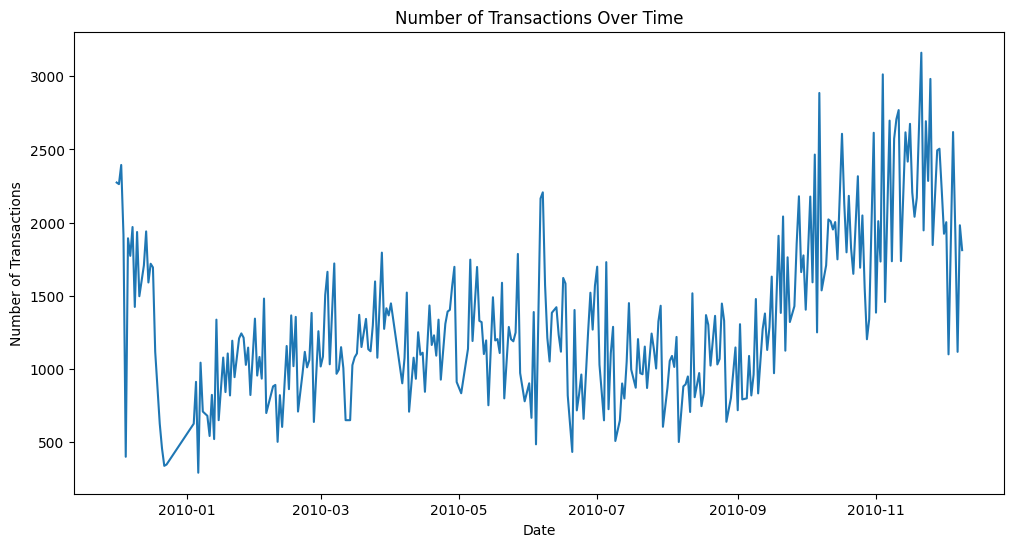

In [45]:
# Formatting date features for plotting
# Convert from string to type:datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Create new 'Date' feature, removing the timestamp
# Making it possilbe to group sales from the same data togther
df['Date'] = df['InvoiceDate'].dt.date
# Group by new 'Date' column and display count of transactions pr date
daily_sales = df.groupby('Date').size()
# Plot
plt.figure(figsize=(12, 6))
daily_sales.plot()
plt.title("Number of Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()

**b. Looking at top selling products**

- Which products can be promoted for campaigns.
- Which products are candidates for a association rule mining analysis.

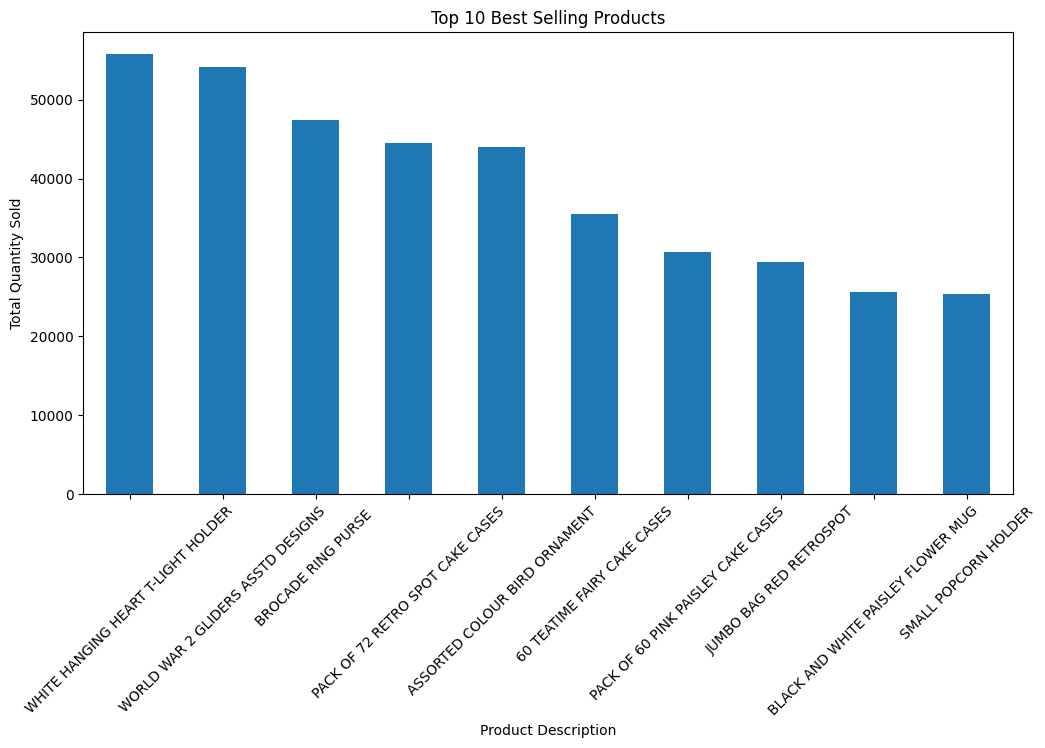

In [46]:
# Group products by their name before plotting
# Count total sum of each product, show 10 highest and sort descending
top_products = df.groupby("Description")["Quantity"].sum().nlargest(10)
# Plot
plt.figure(figsize=(12, 6))
top_products.plot(kind="bar")
plt.title("Top 10 Best Selling Products")
plt.xlabel("Product Description")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45) # Rotate display names for readability
plt.show()

**c. Countries giving the most business**

- Perhaps it's not worth to focus campaign efforts against countires that aren't good customers.

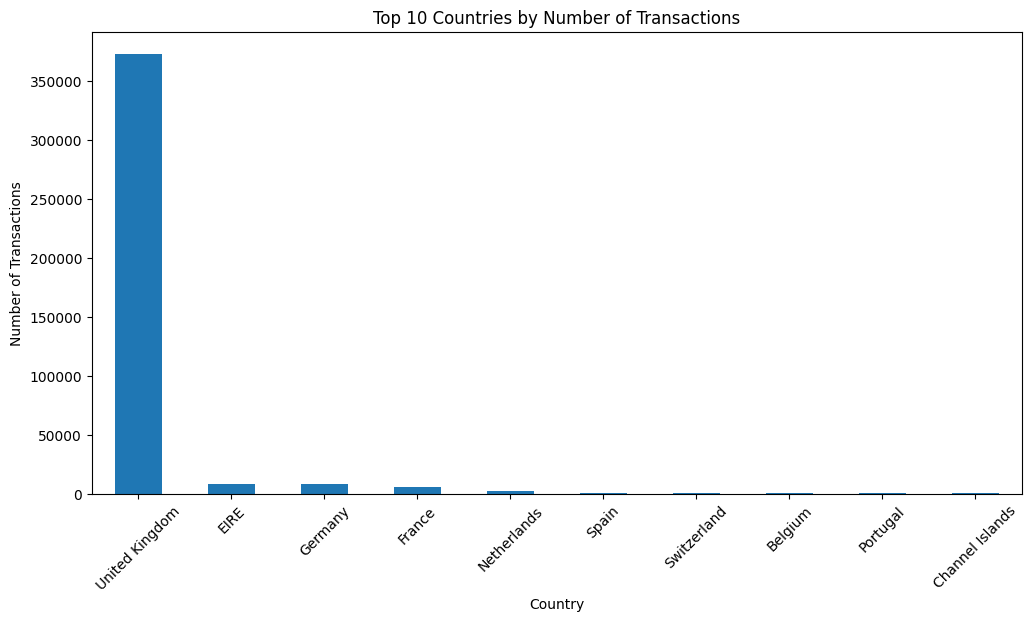

In [47]:
plt.figure(figsize=(12, 6))
# Plot top 10 from output of value_counts
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Country")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45) # Rotate display names again
plt.show()

---

### Feature engineering

Create new features from existing ones, allowing for more precise analysis and use of additional parameters.

Attempting to create the following features:
* **Revenue:** revenue pr item
* **DayOfWeek:** to analyze sales trends by weekdays.
* **TotalRevenue:** for each CustomerID
* **MostPopularProduct:** based on 'Reveune'.
* **Ordersize:** by summing Quantity for each InvoiceNo

In [48]:
# 'Revenue' feature
df['Revenue'] = df['Quantity'] * df['Price']
# Check if it looks correct
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue
285549,517132,22149,FELTCRAFT 6 FLOWER FRIENDS,12,2010-07-27 10:21:00,2.10,13115.0,United Kingdom,2010-07-27,25.20
471652,533816,22906,12 MESSAGE CARDS WITH ENVELOPES,12,2010-11-19 09:16:00,1.65,14932.0,Channel Islands,2010-11-19,19.80
326841,521312,20712,JUMBO BAG WOODLAND ANIMALS,100,2010-09-03 11:54:00,1.95,12939.0,United Kingdom,2010-09-03,195.00
494301,535661,21790,VINTAGE SNAP CARDS,1,2010-11-28 11:33:00,0.85,13069.0,United Kingdom,2010-11-28,0.85
166002,505068,21933,PINK VINTAGE PAISLEY PICNIC BAG,6,2010-04-19 16:50:00,2.55,17850.0,United Kingdom,2010-04-19,15.30


In [49]:
# 'DayOfWeek' feature egnineering
df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
# Check if it looks correct:
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,DayOfWeek
450802,532252,22968,ROSE COTTAGE KEEPSAKE BOX,2,2010-11-11 12:45:00,9.95,17416.0,United Kingdom,2010-11-11,19.90,Thursday
374341,525484,21730,GLASS STAR FROSTED T-LIGHT HOLDER,3,2010-10-05 15:52:00,4.95,14350.0,United Kingdom,2010-10-05,14.85,Tuesday
446921,531922,90214E,"LETTER ""E"" BLING KEY RING",1,2010-11-10 12:09:00,1.25,17974.0,United Kingdom,2010-11-10,1.25,Wednesday
344938,522986,21231,SWEETHEART CERAMIC TRINKET BOX,24,2010-09-19 14:45:00,1.25,13883.0,United Kingdom,2010-09-19,30.00,Sunday
199764,508529,21715,GIRLS VINTAGE TIN SEASIDE BUCKET,224,2010-05-17 11:12:00,1.74,18102.0,United Kingdom,2010-05-17,389.76,Monday


In [50]:
# 'TotalRevenue' feature egnineering
df["TotalRevenue"] = df.groupby("Customer ID")["Revenue"].transform("sum")
# Check if it looks correct:
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,DayOfWeek,TotalRevenue
427746,530288,22508,DOORSTOP RETROSPOT HEART,2,2010-11-02 12:16:00,3.75,14593.0,United Kingdom,2010-11-02,7.50,Tuesday,2951.54
295513,518157,82597,BOMBS AWAY METAL SIGN,48,2010-08-05 09:35:00,1.69,13798.0,United Kingdom,2010-08-05,81.12,Thursday,37222.05
252700,513763,22442,GROW YOUR OWN FLOWERS SET OF 3,2,2010-06-28 13:06:00,7.95,12784.0,Portugal,2010-06-28,15.90,Monday,1230.33
449266,532106,22602,CHRISTMAS RETROSPOT HEART WOOD,12,2010-11-10 16:26:00,0.85,16094.0,United Kingdom,2010-11-10,10.20,Wednesday,2557.33
236402,512286,84836,ZINC METAL HEART DECORATION,2,2010-06-14 14:27:00,1.25,15967.0,United Kingdom,2010-06-14,2.50,Monday,2545.92


In [51]:
# 'MostPopularProduct' feature egnineering
most_popular_product = df.groupby("StockCode")["Revenue"].sum().idxmax()
# Check if it looks correct:
most_popular_product

'85123A'

In [52]:
# 'Ordersize' feature egnineering
df["OrderSize"] = df.groupby("InvoiceNumber")["Quantity"].transform("sum")
# Check if it looks correct:
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,DayOfWeek,TotalRevenue,OrderSize
76734,496343,21986,PACK OF 12 PINK SPOT TISSUES,48,2010-01-31 15:51:00,0.29,13478.0,United Kingdom,2010-01-31,13.92,Sunday,2068.03,277
101062,498931,22148,EASTER CRAFT 4 CHICKS,80,2010-02-24 10:24:00,1.65,12482.0,Sweden,2010-02-24,132.00,Wednesday,21893.53,2224
297779,518394,21942,SKULLS DESIGN FLANNEL,2,2010-08-08 12:35:00,0.85,14606.0,United Kingdom,2010-08-08,1.70,Sunday,18158.22,90
297843,518397,21888,BINGO SET,3,2010-08-08 12:43:00,3.75,16444.0,United Kingdom,2010-08-08,11.25,Sunday,2912.91,169
340721,522622,21385,IVORY HANGING DECORATION HEART,24,2010-09-15 15:32:00,0.85,17589.0,United Kingdom,2010-09-15,20.40,Wednesday,11288.72,933


# ETL Pipeline

To create the extra feature of 'CustomerTier' using lambda, and wrapping all preprocessing steps seen so far in this notebook in a ETL pipeline
* Create a function for loading the data
* Create a function for data cleaning steps
* Create a function for feature engineering
* Create a function applying lambda to create additional features

In [53]:
def load_dataset(file_path):
    return pd.read_excel(file_path)

In [54]:
# Data cleaning
def clean_data(df):
    # Fill missing 'Description' using the most common value per 'StockCode'
    df['Description'] = df.groupby('StockCode')['Description'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
    # Drop rows where 'Customer ID' is missing
    df = df.dropna(subset=['Customer ID'])
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    # Rename 'Invoice' to 'InvoiceNumber'
    df.rename(columns={'Invoice': 'InvoiceNumber'}, inplace=True)
    return df

In [55]:
# Feature engineering
def create_features(df):
    # 'Revenue' feature
    df['Revenue'] = df['Quantity'] * df['Price']
    # 'DayOfWeek' feature
    df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
    # 'TotalRevenue' feature
    df["TotalRevenue"] = df.groupby("Customer ID")["Revenue"].transform("sum")
    # 'MostPopularProduct' feature
    most_popular_product = df.groupby("StockCode")["Revenue"].sum().idxmax()
    df["MostPopularProduct"] = most_popular_product
    # 'OrderSize' feature
    df["OrderSize"] = df.groupby("InvoiceNumber")["Quantity"].transform("sum")
    return df

In [56]:
# Apply lambda functions
def apply_lambda_functions(df):
    # Segment customers into tiers based on TotalRevenue
    df["CustomerTier"] = df["TotalRevenue"].apply(lambda x: "High" if x > 1000 else "Medium" if x > 500 else "Low")
    return df

The result is a reuseable ETL pipeline that apply all these steps to the DF, preparing multiple dataframes in quick succesion

In [57]:
# RSEULT: ETL pipeline
def etl_pipeline(file_path):
    df = load_dataset(file_path)
    df = clean_data(df)
    df = create_features(df)
    df = apply_lambda_functions(df)
    return df

In [59]:
# Freshly declared a new dataframe to test the pipeline, it will preproccess the data the same way as i did manually in the notebook
new_df = etl_pipeline(file_path)
new_df.head()

C:\Users\danie\AppData\Local\Temp\ipykernel_23328\262416665.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
C:\Users\danie\AppData\Local\Temp\ipykernel_23328\262416665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Invoice': 'InvoiceNumber'}, inplace=True)


,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,DayOfWeek,TotalRevenue,MostPopularProduct,OrderSize,CustomerTier
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,Tuesday,1187.08,85123A,166,High
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Tuesday,1187.08,85123A,166,High
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Tuesday,1187.08,85123A,166,High
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,Tuesday,1187.08,85123A,166,High
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,Tuesday,1187.08,85123A,166,High
